<a href="https://colab.research.google.com/github/Anku5hk/The_ML_Workflow/blob/master/Pytorch/Object_Detection/Train_Object_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 2 which will train Faster R-CNN with the previously trained Resnet18 car classifier using pytorch.

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import torch, torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

torch.manual_seed(1)
np.random.seed(42)
device = torch.device('cuda:0')

In [ ]:
print(torch.cuda.get_device_name(0)) 

Tesla P4


In [ ]:
!wget https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz

--2020-07-06 08:37:24--  https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘car_devkit.tgz’

car_devkit.tgz      100%[===================>] 323.20K   191KB/s    in 1.7s    

2020-07-06 08:37:27 (191 KB/s) - ‘car_devkit.tgz’ saved [330960/330960]



In [ ]:
!tar -xzvf /content/car_devkit.tgz

devkit/
devkit/cars_meta.mat
devkit/cars_train_annos.mat
devkit/cars_test_annos.mat
devkit/README.txt
devkit/train_perfect_preds.txt
devkit/eval_train.m


In [ ]:
# !wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz
a = '/content/cars_train.tgz'
b = '/content/drive/My Drive/Datasets/stanf_cars.tgz'
import shutil

shutil.copyfile(b,a)

tar (child): /content/stanf_cars.tgz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [ ]:
# !tar -xzvf /content/cars_train.tgz

In [ ]:
ROOT_DIR = '/content/cars_train/'
cars = os.listdir(ROOT_DIR)[:5000]
print('Total images',len(cars))

Total images 5000


In [ ]:
import scipy.io

mat = scipy.io.loadmat('/content/devkit/cars_train_annos.mat')
annotations = mat['annotations'][0]
i1 = '/content/cars_train/00001.jpg'

Make Annotations

In [ ]:
# make dataframe of annotaiton values

annotations_array = []

for i in annotations:
  x1= i[0].item()
  y1= i[1].item()
  x2= i[2].item()
  y2= i[3].item()
  names= i[5].item()
  a = np.array([names, x1,x2,y1,y2]).reshape(1,-1)
  annotations_array.append(a)

cols = ['image_id', 'x1','x2','y1','y2']
a = np.array(annotations_array).reshape(-1,5)

df = pd.DataFrame(a,columns=cols)
df.head()

,image_id,x1,x2,y1,y2
0,00001.jpg,39,569,116,375
1,00002.jpg,36,868,116,587
2,00003.jpg,85,601,109,381
3,00004.jpg,621,1484,393,1096
4,00005.jpg,14,133,36,99


In [ ]:
# turn them to int

df = df.astype({'x1': 'int32', 'x2': 'int32', 
                'y1': 'int32', 'y2': 'int32'})
df.dtypes

image_id    object
x1           int32
x2           int32
y1           int32
y2           int32
dtype: object

Sample Images

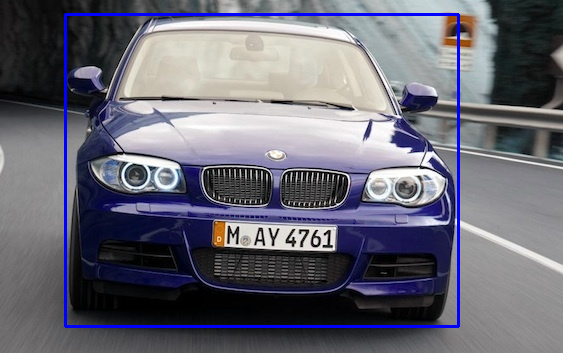

In [ ]:
# sample dataset

im = 0
for img in os.listdir(ROOT_DIR):
    a = df[df['image_id'] == img]
    x1 = a['x1'].values
    y1 = a['y1'].values
    x2 = a['x2'].values
    y2 = a['y2'].values
    img = cv2.imread(ROOT_DIR + img)
    cv2.rectangle(img, (x1,y1), (x2, y2), (0,0,255), 2)
    im = img
    break
Image.fromarray(im)

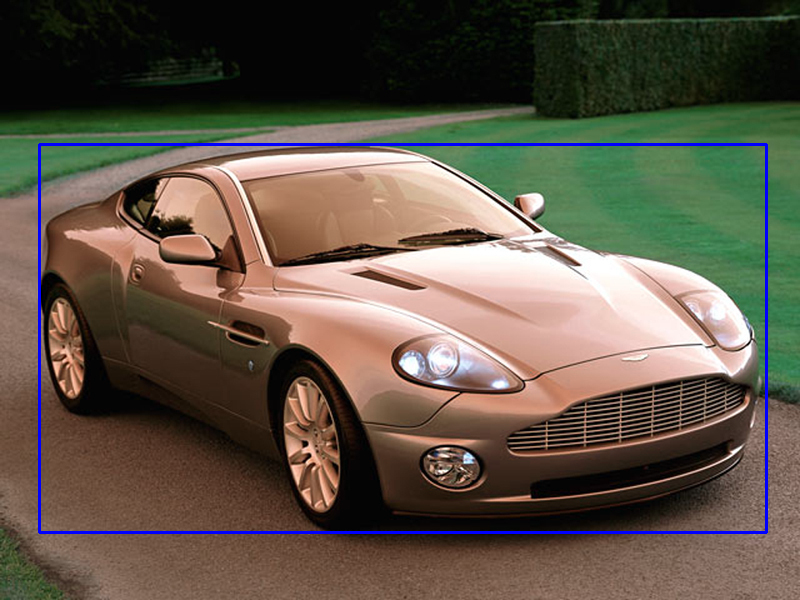

In [ ]:

im = 0
for img in os.listdir(ROOT_DIR):
    im+=1
    if im ==7:
      a = df[df['image_id'] == img]
      x1 = a['x1']
      y1 = a['y1']
      x2 = a['x2']
      y2 = a['y2']
      img = cv2.imread(ROOT_DIR + img)
      cv2.rectangle(img, (x1,y1), (x2, y2), (0,0,255), 2)
      im = img
      break
Image.fromarray(im)

Make Dataset

In [ ]:
# create dataset

class make_dataset(Dataset):

  def __init__(self, image_dir, annotations_df, train = True, transform=False):
    self.image_dir = image_dir
    self.image_ids = [img for img in os.listdir(image_dir)]
    self.annotations = annotations_df
    self.transform = transform
    
    if train:
        self.image_ids = self.image_ids[:5000]
    else:
        self.image_ids = self.image_ids[5000:]

    self.len = np.array(self.image_ids).shape[0]

  def __len__(self):
    return self.len

  def __getitem__(self, index):

    image_id = self.image_ids[index]
    image = Image.open(self.image_dir + image_id).convert("RGB")
    image = np.array(image, dtype=np.float32)
    image/=255.0
    anno = self.annotations[self.annotations['image_id'] == image_id] # contains boxes,labels,image_id
    # take only boxes
    x1 = anno['x1'].values
    y1 = anno['y1'].values
    x2 = anno['x2'].values
    y2 = anno['y2'].values

    boxes = torch.as_tensor([[x1[0], y1[0], x2[0], y2[0]]], 
                            dtype=torch.float32)
    # only cars so 1 label
    labels = torch.ones((1,), dtype=torch.int64)
    area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
    area = torch.as_tensor(area, dtype=torch.float32)
    iscrowd = torch.zeros((1,), dtype=torch.int64)

    target = {}
    target['boxes'] = boxes
    target['area'] = area
    target['labels'] = labels
    target['iscrowd'] = iscrowd
    target['image_id'] = torch.tensor([index])

    if self.transform:
      image = self.transform(image)

    return image, target


In [ ]:
train_dataset[0] # check output of dataset

(tensor([[[0.0824, 0.0824, 0.0863,  ..., 0.1451, 0.1451, 0.1451],
          [0.0824, 0.0824, 0.0902,  ..., 0.1294, 0.1294, 0.1294],
          [0.0784, 0.0824, 0.0902,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.4157, 0.4392, 0.4510,  ..., 0.5294, 0.5294, 0.5294],
          [0.4392, 0.4392, 0.4314,  ..., 0.5373, 0.5333, 0.5294],
          [0.4549, 0.4314, 0.4118,  ..., 0.5294, 0.5333, 0.5373]],
 
         [[0.0824, 0.0824, 0.0863,  ..., 0.1529, 0.1529, 0.1529],
          [0.0824, 0.0824, 0.0902,  ..., 0.1373, 0.1373, 0.1373],
          [0.0784, 0.0824, 0.0902,  ..., 0.1412, 0.1412, 0.1412],
          ...,
          [0.4157, 0.4392, 0.4510,  ..., 0.5294, 0.5294, 0.5294],
          [0.4392, 0.4392, 0.4314,  ..., 0.5373, 0.5333, 0.5294],
          [0.4549, 0.4314, 0.4118,  ..., 0.5294, 0.5333, 0.5373]],
 
         [[0.0824, 0.0824, 0.0863,  ..., 0.1020, 0.1020, 0.1020],
          [0.0824, 0.0824, 0.0902,  ..., 0.0863, 0.0863, 0.0863],
          [0.0784, 0.0824, 0.0902,  ...,

In [ ]:
# make datasets

transform = transforms.Compose([ transforms.ToTensor()])

train_dataset = make_dataset(ROOT_DIR, df, transform=transform, train=True)
val_dataset = make_dataset(ROOT_DIR, df, transform=transform, train=False)

In [ ]:
print('Train Dataset {} and Test Dataset {}'.format(len(train_dataset), len(val_dataset)))

Train Dataset 5000 and Test Dataset 3144


In [ ]:
train_dataset[0][0].shape

torch.Size([3, 794, 1187])

In [ ]:
# make dataloaders

BATCH_SIZE = 16

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, 
                                           shuffle=True, collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1,
                                         shuffle=False, collate_fn=collate_fn)

Make Model

In [ ]:
# use resnet classifier as backbone

numer_of_classes = 2 # 1 background class

model_path = '/content/drive/My Drive/train/resnet_carclassifer.pt'
  
backbone = models.resnet18(pretrained=False).cuda(0) # no pretrained
backbone.requires_grad_(False)
backbone.fc = torch.nn.Linear(in_features=512, out_features=2).cuda(0)
backbone.fc.requires_grad_(False)
backbone.load_state_dict(torch.load(model_path))
backbone = torch.nn.Sequential(*(list(backbone.children())[:-3]))
backbone.out_channels = 256 # resnets output number of features

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler).cuda(0)

In [ ]:
backbone

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# find backbones output features

# print(img.shape)
img = torch.tensor(img, dtype=torch.float32, device=device).reshape((1, 3, 400, 600))
backbone.eval()
z = backbone(img)
z.shape[1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


256

In [ ]:
 #some useful functions
!git clone https://github.com/pytorch/vision.git

!cp /content/vision/references/detection/engine.py /content/
!cp /content/vision/references/detection/utils.py /content/
!cp /content/vision/references/detection/transforms.py /content/
!cp /content/vision/references/detection/coco_eval.py /content/
!cp /content/vision/references/detection/coco_utils.py /content/

Cloning into 'vision'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 8832 (delta 9), reused 23 (delta 3), pack-reused 8790
Receiving objects: 100% (8832/8832), 10.46 MiB | 704.00 KiB/s, done.
Resolving deltas: 100% (6078/6078), done.


Train

In [ ]:
from engine import train_one_epoch, evaluate

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001,
                            momentum=0.9, weight_decay=0.0001)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

# let's train it for 5 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, val_loader, device=device)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Epoch: [0]  [   0/2500]  eta: 0:05:50  lr: 0.000002  loss: 1.5049 (1.5049)  loss_classifier: 0.7052 (0.7052)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.6948 (0.6948)  loss_rpn_box_reg: 0.1049 (0.1049)  time: 0.1404  data: 0.0327  max mem: 7074
Epoch: [0]  [  10/2500]  eta: 0:05:00  lr: 0.000012  loss: 1.6005 (1.6106)  loss_classifier: 0.7045 (0.7044)  loss_box_reg: 0.0033 (0.0035)  loss_objectness: 0.6948 (0.6948)  loss_rpn_box_reg: 0.2013 (0.2078)  time: 0.1206  data: 0.0265  max mem: 7074
Epoch: [0]  [  20/2500]  eta: 0:04:41  lr: 0.000022  loss: 1.6574 (1.6664)  loss_classifier: 0.7032 (0.7033)  loss_box_reg: 0.0000 (0.0026)  loss_objectness: 0.6947 (0.6947)  loss_rpn_box_reg: 0.2430 (0.2658)  time: 0.1124  data: 0.0217  max mem: 7074
Epoch: [0]  [  30/2500]  eta: 0:04:42  lr: 0.000032  loss: 1.7235 (1.7037)  loss_classifier: 0.7004 (0.7013)  loss_box_reg: 0.0000 (0.0028)  loss_objectness: 0.6948 (0.6948)  loss_rpn_box_reg: 0.3334 (0.3047)  time: 0.1110  data: 0.0221  max me

In [ ]:
PATH = '/content/drive/My Drive/train/resnet_cardetector.pt'
torch.save(model.state_dict(), PATH)
print('Model Saved')

Model Saved


In [ ]:
# torch.cuda.empty_cache()

Results

In [ ]:
# pick one image from the test set
img, _ = val_dataset[50]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [ ]:
prediction

[{'boxes': tensor([[ 46.0744, 106.6388, 600.9896, 422.5862],
          [ 14.8372,   0.0000, 503.1538, 298.9920]], device='cuda:0'),
  'labels': tensor([1, 1], device='cuda:0'),
  'scores': tensor([0.9420, 0.0568], device='cuda:0')}]

In [ ]:
b = prediction[0]['boxes'][0].cpu().numpy()

In [ ]:
img_sample = img.mul(255).permute(1, 2, 0).byte().numpy()

In [ ]:
img_sample.shape

(518, 720, 3)

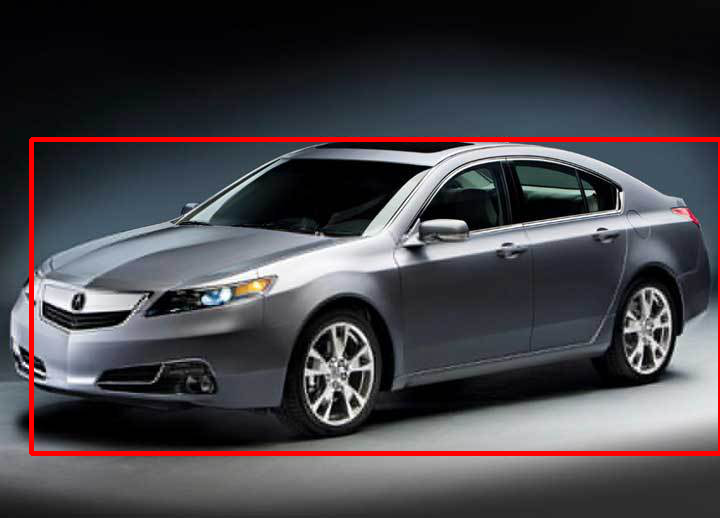

In [ ]:
# img1 = img1.mul(255)
cv2.rectangle(img_sample, (b[0], b[1]), (b[2], b[3]), (255,0,0), 3)
Image.fromarray(img_sample)

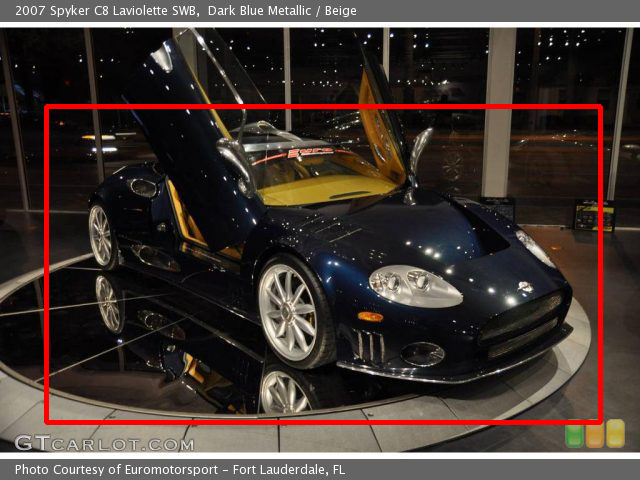

In [ ]:
cv2.rectangle(img_sample, (b[0], b[1]), (b[2], b[3]), (255,0,0), 3)
Image.fromarray(img_sample)

Looks Fine enough